In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("data/AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [2]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.columns = ['Passengers']
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

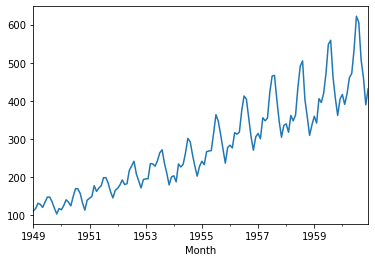

In [3]:
df['Passengers'].plot()

### Stationarity Test

##### Rolling Mean method

We will now plot the moving average and moving standard deviation to see if it varies with time.

In [4]:
rolling_mean = df['Passengers'].rolling(window=12).mean()
rolling_std = df['Passengers'].rolling(window=12).std()

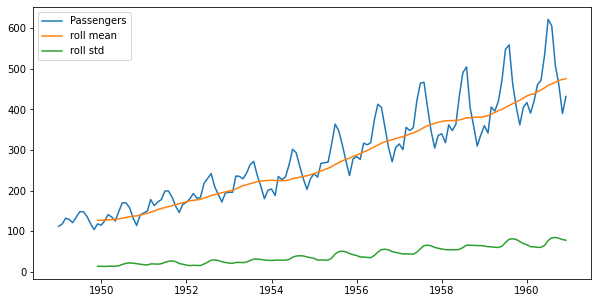

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df['Passengers'],label='Passengers')
plt.plot(rolling_mean,label='roll mean')
plt.plot(rolling_std,label='roll std')
plt.legend()
plt.show()

We can observe in the above plot that the data is non-stationary. <br>
Let's now perform the adfuller test to confirm the same.

###### ADfuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
adfuller(df['Passengers'])

(0.8153688792060468,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:
def adfuller_test(series):
    results = adfuller(series)
    labels = ['Adf Test Statistics','p value','Lags Used','No of Observations','critical values']
    for value,label in zip(results,labels):
        print(label,":",value)
    if(results[1]<0.05):
        print("Reject Null Hypothesis, Series is stationary")
    else:
        print("weak evidence against null hypothesis,Series is non stationary")
    
adfuller_test(df['Passengers'])

Adf Test Statistics : 0.8153688792060468
p value : 0.991880243437641
Lags Used : 13
No of Observations : 130
critical values : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
weak evidence against null hypothesis,Series is non stationary


Test suggests that the series is non stationary.
So we proceed further to make it stationary by differencing

### Differencing

In [9]:
df['Passengers first difference'] = df['Passengers']-df['Passengers'].shift(12)
df.dropna(inplace=True)
df.head(15)

,Passengers,Passengers first difference
Month,,
1950-01-01,115,3.0
1950-02-01,126,8.0
1950-03-01,141,9.0
1950-04-01,135,6.0
1950-05-01,125,4.0
1950-06-01,149,14.0
1950-07-01,170,22.0
1950-08-01,170,22.0
1950-09-01,158,22.0


###### Stationarity test for new column

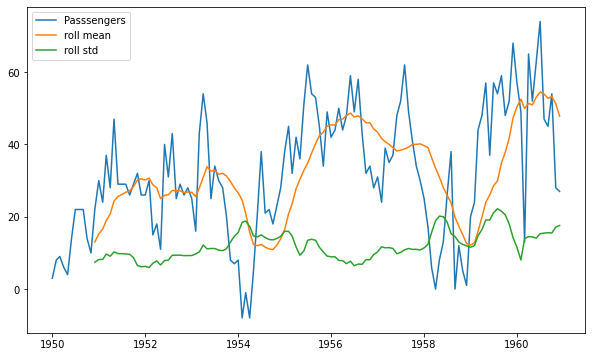

Adf Test Statistics : -3.383020726492481
p value : 0.011551493085514952
Lags Used : 1
No of Observations : 130
critical values : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Reject Null Hypothesis, Series is stationary


In [10]:
rolling_mean2 = df['Passengers first difference'].rolling(window=12).mean()
rolling_std2 = df['Passengers first difference'].rolling(window=12).std()

plt.figure(figsize=(10,6))
plt.plot(df['Passengers first difference'],label='Passsengers')
plt.plot(rolling_mean2,label='roll mean')
plt.plot(rolling_std2,label="roll std")
plt.legend()
plt.show()
adfuller_test(df['Passengers first difference'])

We can observe here that the series is stationary so we can now proceed further with our model.

### Modelling

In [11]:
import statsmodels.api as sm

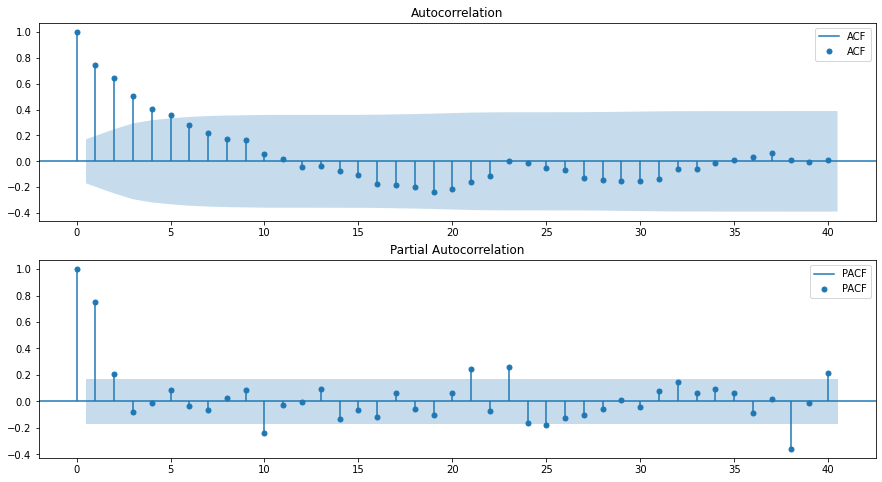

In [21]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df['Passengers first difference'],lags=40,label='ACF',ax=ax1)
plt.legend()
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df['Passengers first difference'],lags=40,label='PACF',ax=ax2)
plt.legend()
plt.show()

As the pacf graph shuts off after 1 so we take p=2<br>
and we take q=5

### ARIMA

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
# p=2,d=1,q=5
model = ARIMA(df['Passengers'],order=(2,1,5))
model_fit = model.fit()

C:\Users\manda\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manda\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [47]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  131
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -609.989
Method:                       css-mle   S.D. of innovations             24.414
Date:                Sat, 27 Mar 2021   AIC                           1237.978
Time:                        20:15:58   BIC                           1263.855
Sample:                    02-01-1950   HQIC                          1248.493
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.7906      0.155     18.003      0.000       2.487       3.094
ar.L1.D.Passengers     0.9161      0.089     10.335      0.000       0.742       1.090
ar.L2.D.Passengers  

<AxesSubplot:xlabel='Month'>

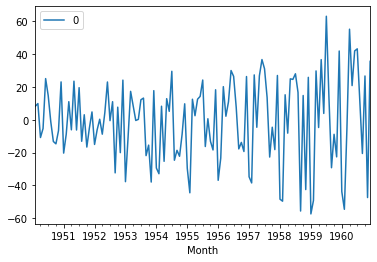

In [48]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

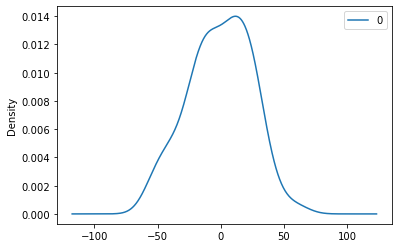

In [49]:
residuals.plot(kind='kde')

<AxesSubplot:xlabel='Month'>

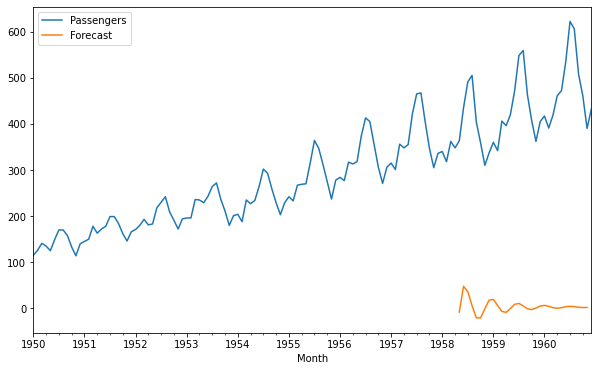

In [50]:
df['Forecast'] = model_fit.predict(start=100,end=131,dynamic=True)
df[['Passengers','Forecast']].plot(figsize=(10,6))

#### As the data is seasonal, ARIMA did not work well.

### Seasonal ARIMA

In [28]:
model = sm.tsa.statespace.SARIMAX(df['Passengers'],order=(2,1,5),seasonal_order=(2,1,5,12))
results = model.fit()
print(results.summary())

C:\Users\manda\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manda\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manda\Miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -449.378
Date:                            Wed, 31 Mar 2021   AIC                            928.755
Time:                                    18:40:41   BIC                            970.442
Sample:                                01-01-1950   HQIC                           945.683
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1188      0.059    -19.124      0.000      -1.234      -1.004
ar.L2         -0.9839      0.048   

<AxesSubplot:xlabel='Month'>

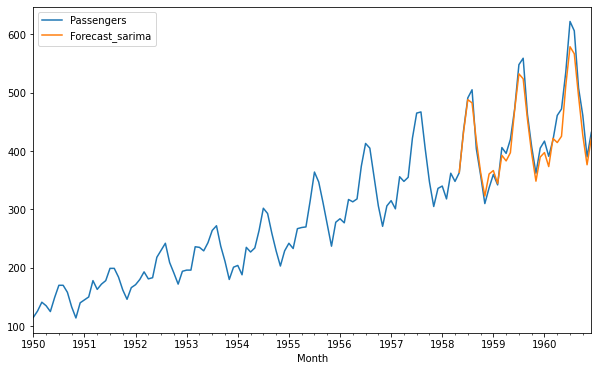

In [23]:
df['Forecast_sarima'] = results.predict(start=100,end=131,dynamic=True)
df[['Passengers','Forecast_sarima']].plot(figsize=(10,6))

In [79]:
df.shape

(132, 4)

In [80]:
df.tail()

,Passengers,Passengers first difference,Forecast,Forecast_sarima
Month,,,,
1960-08-01,606,47.0,3.726048,561.039354
1960-09-01,508,45.0,2.340806,482.813069
1960-10-01,461,54.0,1.655619,422.797516
1960-11-01,390,28.0,2.098455,374.534676
1960-12-01,432,27.0,NaN,409.843948


###### Let's now forecast for future dates

In [24]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [25]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dataset_df.tail()

,Passengers,Passengers first difference,Forecast_sarima
1962-07-01,NaN,NaN,NaN
1962-08-01,NaN,NaN,NaN
1962-09-01,NaN,NaN,NaN
1962-10-01,NaN,NaN,NaN
1962-11-01,NaN,NaN,NaN


In [26]:
future_df = pd.concat([df,future_dataset_df])

<AxesSubplot:>

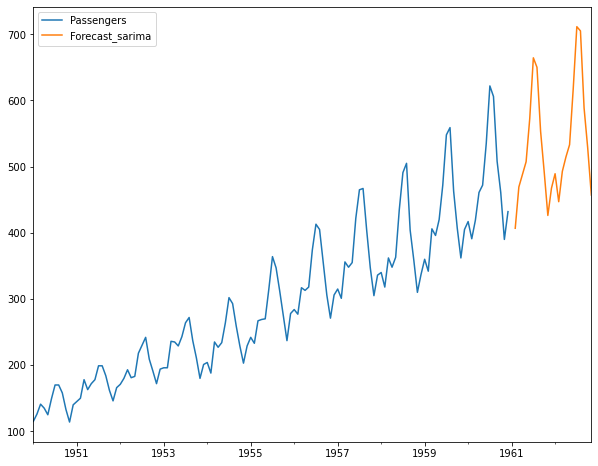

In [27]:
future_df['Forecast_sarima'] = results.predict(start=133,end=160)
future_df[['Passengers','Forecast_sarima']].plot(figsize=(10,8))